In [1]:
#Toy example with English text
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import imutils
from imutils import contours
import pandas as pd
from PIL import Image as im
from scipy import ndimage
from scipy.ndimage import interpolation as inter

In [2]:
def correct_skew(image, delta=1, limit=5):
    def determine_score(arr, angle):
        data = ndimage.rotate(arr, angle, reshape=False, order=0)
        histogram = np.sum(data, axis=1, dtype=float)
        score = np.sum((histogram[1:] - histogram[:-1]) ** 2, dtype=float)
        return histogram, score

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1] 

    scores = []
    angles = np.arange(-limit, limit + delta, delta)
    for angle in angles:
        histogram, score = determine_score(thresh, angle)
        scores.append(score)

    best_angle = angles[scores.index(max(scores))]

    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, best_angle, 1.0)
    corrected = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, \
            borderMode=cv2.BORDER_REPLICATE)

    return best_angle, corrected

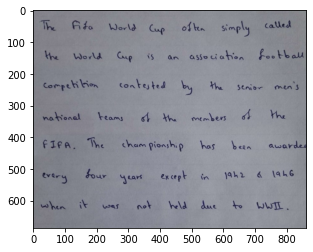

In [3]:
input_img=cv2.imread('dataset/word-segmentation.jpg')
input_img=cv2.cvtColor(input_img,cv2.COLOR_BGR2RGB)
h,w,c=input_img.shape
if w>1000:
    new_w=1000
    ar=w/h
    new_h=int(new_w/ar)
    input_img=cv2.resize(input_img,(new_w,new_h),interpolation=cv2.INTER_AREA)
angle,rotated=correct_skew(input_img)
plt.imshow(rotated)

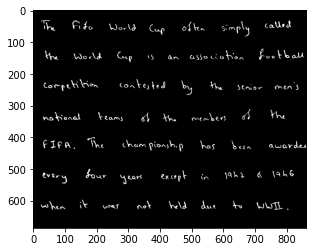

In [4]:
def thresholding(image):
    img_gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    ret,thresh = cv2.threshold(img_gray,80,255,cv2.THRESH_BINARY_INV)
    plt.imshow(thresh, cmap='gray')
    return thresh
thresh_img = thresholding(rotated);

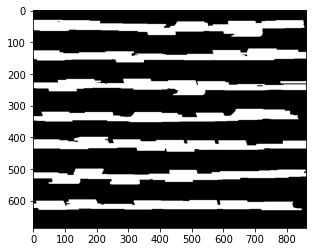

In [5]:
#dilation
kernel = np.ones((3,85), np.uint8)
dilated = cv2.dilate(thresh_img, kernel, iterations = 1)
plt.imshow(dilated, cmap='gray');

In [6]:
(cts, heirarchy) = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
#sorted_contours_lines = sorted(cts, key = lambda ctr : cv2.boundingRect(ctr)[1]) # (x, y, w, h)
sorted_contours_lines=contours.sort_contours(cts, method='bottom-to-top')[0]

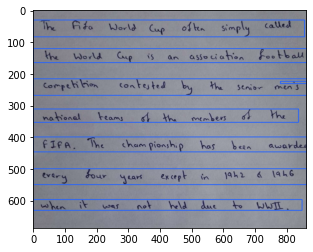

In [7]:
img2 = input_img.copy()
for ctr in sorted_contours_lines:
    x,y,w,h = cv2.boundingRect(ctr)
    cv2.rectangle(img2, (x,y), (x+w, y+h), (40, 100, 250), 2)
plt.imshow(img2);

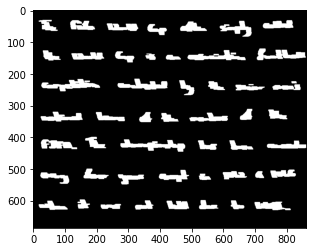

In [8]:
#dilation
kernel = np.ones((3,15), np.uint8)
dilated2 = cv2.dilate(thresh_img, kernel, iterations = 1)
plt.imshow(dilated2, cmap='gray');

53


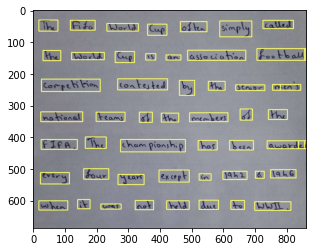

In [9]:
img3 = input_img.copy()
words_list = []
tracker=[]
for line in sorted_contours_lines:
    count=0
    # roi of each line
    x, y, w, h = cv2.boundingRect(line)
    roi_line = dilated2[y:y+w, x:x+w]
    
    # draw contours on each word
    (cnt, hierarchy) = cv2.findContours(roi_line.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    #sorted_contour_words = sorted(cnt, key=lambda cntr : cv2.boundingRect(cntr)[0])
    sorted_contour_words=contours.sort_contours(cnt, method='right-to-left')[0]
    
    for word in sorted_contour_words:
        if cv2.contourArea(word) < 400:
            continue
        count+=1
        x2, y2, w2, h2 = cv2.boundingRect(word)
        t=(x+x2, y+y2, x+x2+w2, y+y2+h2)
        if t in tracker:
            continue
        else:
            tracker.append(t)
        words_list.insert(0,[x+x2, y+y2, x+x2+w2, y+y2+h2])
        cv2.rectangle(img3, (x+x2, y+y2), (x+x2+w2, y+y2+h2), (255,255,100),2)  
print(len(words_list))
plt.imshow(img3);

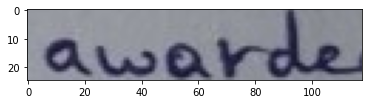

In [10]:
ninth_word = words_list[8]
roi_9 = input_img[ninth_word[1]:ninth_word[3], ninth_word[0]:ninth_word[2]]
angle,corrected=correct_skew(roi_9)
plt.imshow(corrected)

In [11]:
model=tf.keras.models.load_model('saved_model/model')
mapping={}
cap_alphabet="abcdefghijklmnopqrstuvwxyz".upper()
lower_alphabet='abcdefghijklmnopqrstuvwxyz'
for i in range(10):
    mapping[i]=i
for number,c in enumerate(cap_alphabet):
    mapping[number+10]=c
for number,c in enumerate(lower_alphabet):
    mapping[number+36]=c

In [ ]:
text=''
for word in words_list:
    roi=input_img[word[1]:word[3],word[0]:word[2]]
    angle,corrected=correct_skew(roi)
    image = corrected.copy()
    image = imutils.resize(image, width=500)
    img=image.copy()
    # Remove border
    kernel_vertical = cv2.getStructuringElement(cv2.MORPH_RECT, (1,50))
    temp1 = 255 - cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel_vertical)
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (50,1))
    temp2 = 255 - cv2.morphologyEx(img, cv2.MORPH_CLOSE, horizontal_kernel)
    result = cv2.add(temp2, img)
    dst = cv2.fastNlMeansDenoisingColored(result, None, 3, 10, 7, 21)
    # Convert to grayscale and Otsu's threshold
    gray = cv2.cvtColor(dst, cv2.COLOR_BGR2GRAY)

    gray = cv2.GaussianBlur(gray,(5,5),0)
    _,thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
    #thresh=cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
    thresh=cv2.dilate(thresh,None,iterations=1)
    kernel=np.ones((3,3),np.uint8)
    erosion=cv2.erode(thresh,kernel,iterations=1)
    # Find contours and filter using contour area
    cnts = cv2.findContours(erosion, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[0]
    MIN_AREA=45
    digit_contours = []
    for c in cnts:
        if cv2.contourArea(c)>MIN_AREA:
            x,y,w,h = cv2.boundingRect(c)
            cv2.rectangle(img, (x, y), (x + w, y + h), (36,255,12), 2)
            digit_contours.append(c)
    imgs=[]
    sorted_digit_contours = contours.sort_contours(digit_contours, method='left-to-right')[0]
    contour_number = 0
    for c in sorted_digit_contours:
        x,y,w,h = cv2.boundingRect(c)
        ROI = image[y:y+h, x:x+w]
        imgs.append(erosion[y:y+h, x:x+w])
        cv2.imwrite('dataset/segment_{}.png'.format(contour_number), thresh[y:y+h, x:x+w])
        contour_number += 1
    input_mat=[]
    for i in imgs:
        new_i=cv2.resize(i,(28,28))
        input_mat.append(new_i)
    input_mat=np.array(input_mat).astype('float32')/255.0
    predictions=model.predict(input_mat)
    word=''
    for i in predictions:
        word+=str(mapping[i.argmax()])
    cv2.imshow('thresh', erosion)
    cv2.imshow('img',img)
    cv2.waitKey()
    text+=word+' '
text=text.rstrip()
print(text)